In [131]:
print("hello")

hello


In [132]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-2.5-pro')
output=model.invoke("hi")
print(output.content)

Hello! How can I help you today?


In [133]:
op = model.invoke("Hi")
print(op.content)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 55.505004816s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds

Hello! How can I help you today?


In [134]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

In [135]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [136]:
loader = DirectoryLoader("..\data",glob="./*.txt",loader_cls=TextLoader)
docs = loader.load()

In [137]:
docs


[Document(metadata={'source': '..\\data\\india.txt'}, page_content="🇮🇳 Overview of the Indian Economy\n\nIndia, with a population exceeding 1.46 billion, stands as the world's fifth-largest economy by nominal GDP and the third-largest by Purchasing Power Parity (PPP). Operating under a mixed economy, it combines elements of both capitalism and socialism, with a significant role played by the private sector alongside substantial government involvement in areas like infrastructure, education, and healthcare. India's economy is characterized by a diverse industrial base, a rapidly growing services sector, and a substantial agricultural output.\n\n📊 India’s GDP – Size, Composition, and Global Share\n\nNominal GDP (FY 2024–25): ₹330.68 lakh crore (~$4.0 trillion USD), reflecting a 9.8% increase from the previous fiscal year.\n\nGDP per capita (2024): $2,698, indicating a moderate standard of living.\n\nGDP by Sector (2024–25):\n\nServices: 54.93%\n\nIndustry: 27.13%\n\nAgriculture: 17.94%\n

In [138]:
len(docs[0].page_content)

3798

In [139]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=50
)

In [140]:
new_docs=text_splitter.split_documents(documents=docs)


In [141]:
len(new_docs)
new_docs

[Document(metadata={'source': '..\\data\\india.txt'}, page_content='🇮🇳 Overview of the Indian Economy'),
 Document(metadata={'source': '..\\data\\india.txt'}, page_content="India, with a population exceeding 1.46 billion, stands as the world's fifth-largest economy by nominal GDP and the third-largest by Purchasing Power Parity (PPP). Operating under a mixed economy, it combines elements of both capitalism and"),
 Document(metadata={'source': '..\\data\\india.txt'}, page_content="it combines elements of both capitalism and socialism, with a significant role played by the private sector alongside substantial government involvement in areas like infrastructure, education, and healthcare. India's economy is characterized by a"),
 Document(metadata={'source': '..\\data\\india.txt'}, page_content="healthcare. India's economy is characterized by a diverse industrial base, a rapidly growing services sector, and a substantial agricultural output."),
 Document(metadata={'source': '..\\data\\ind

In [142]:
doc_string=[doc.page_content for doc in new_docs]


In [143]:
doc_string

['🇮🇳 Overview of the Indian Economy',
 "India, with a population exceeding 1.46 billion, stands as the world's fifth-largest economy by nominal GDP and the third-largest by Purchasing Power Parity (PPP). Operating under a mixed economy, it combines elements of both capitalism and",
 "it combines elements of both capitalism and socialism, with a significant role played by the private sector alongside substantial government involvement in areas like infrastructure, education, and healthcare. India's economy is characterized by a",
 "healthcare. India's economy is characterized by a diverse industrial base, a rapidly growing services sector, and a substantial agricultural output.",
 '📊 India’s GDP – Size, Composition, and Global Share\n\nNominal GDP (FY 2024–25): ₹330.68 lakh crore (~$4.0 trillion USD), reflecting a 9.8% increase from the previous fiscal year.',
 'GDP per capita (2024): $2,698, indicating a moderate standard of living.\n\nGDP by Sector (2024–25):\n\nServices: 54.93%\n\nIn

In [144]:
len(doc_string)


22

In [145]:
db=Chroma.from_documents(new_docs,embeddings)


In [146]:
retriever = db.as_retriever(search_kwargs={"k":3})


In [147]:
retriever.invoke("industrial growth of India?")


[Document(metadata={'source': '..\\data\\india.txt'}, page_content='🇮🇳 Overview of the Indian Economy'),
 Document(metadata={'source': '..\\data\\india.txt'}, page_content='🇮🇳 Overview of the Indian Economy'),
 Document(metadata={'source': '..\\data\\india.txt'}, page_content='🇮🇳 Overview of the Indian Economy')]

Till thgis point I have setup initial RAG pipeline with LLM, embeddings, and Chroma retriever

- Initialized Google Gemini 2.5 Pro model using ChatGoogleGenerativeAI
- Created Hugging Face embeddings (BAAI/bge-small-en)
- Loaded and split documents using TextLoader / DirectoryLoader and RecursiveCharacterTextSplitter
- Stored embeddings in Chroma DB
- Created a retriever for search over document chunks


In [148]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain_core.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

                                        Defining structured output using Pydantic

In [149]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [151]:
# Connecting the Pydantic schema with LangChain’s parser
from langchain_core.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)


                                                    Creating Agent class

In [152]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

                                                    Creating the superviser fun (Decision-maker)

In [153]:
# This node decides if a user question is related to India or not.
def function_1(state: AgentState):
    question = state["messages"][-1]  # get the most recent user question
    print("Question:", question)

    # Prompt to guide the LLM to categorize the question cleanly
    template = """
    Classify the user query into one of these categories: [India, Not Related].
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    # Prepare prompt with format instructions
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    # Chain: prompt → model → structured parser
    chain = prompt | model | parser

    # Run the chain and capture structured output
    response = chain.invoke({"question": question})
    print("Parsed response:", response)

    # Return only the topic (India / Not Related) for next node routing
    return {"messages": [response.Topic]}

                                                    Router Function

In [154]:
# Based on topic, route to either RAG (contextual) or LLM (general).
def router(state: AgentState):
    print("-> ROUTER ->")
    last_message = state["messages"][-1]
    print("Last Message:", last_message)

    # Simple routing logic
    if "india" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"


In [ ]:
# Formating the docs
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


                                                        RAG function

In [156]:
def function_2(state: AgentState):
    print("-> RAG Call ->")
    question = state["messages"][0]  # fetch question from state

    # Build a simple retrieval-based QA prompt
    prompt = PromptTemplate(
        template="""
        You are a helpful assistant for Q&A tasks.
        Use the context below to answer concisely.
        If the answer isn’t in context, just say you don’t know.

        Question: {question}
        Context: {context}
        Answer:
        """,
        input_variables=["context", "question"]
    )

    # RAG chain = retriever → prompt → model → string parser
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    return {"messages": [result]}



                                                        LLM function

In [157]:
def function_3(state: AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]

    # No RAG here — purely model-based response
    full_prompt = "Answer this question using your general knowledge: " + question
    response = model.invoke(full_prompt)
    return {"messages": [response.content]}


                                                                Building the workflow

In [158]:
# Defining nodes and edges to form a pipeline.
workflow = StateGraph(AgentState)


In [159]:
# Adding all nodes
workflow.add_node("Supervisor", function_1)
workflow.add_node("RAG", function_2)
workflow.add_node("LLM", function_3)


In [160]:
# Setting the entry node — Supervisor runs first
workflow.set_entry_point("Supervisor")

In [161]:
# Conditional routing after Supervisor’s decision
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)


In [162]:
# End points — both RAG and LLM end here
workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

In [163]:
# Compile into an executable graph
app = workflow.compile()

                                                    Testing it

In [164]:
# Case 1: Should go to RAG (India-related query)
state = {"messages": ["What is the GDP of India?"]}
app.invoke(state)



Question: What is the GDP of India?
Parsed response: Topic='India' Reasoning='The user query explicitly asks a question about the GDP of India.'
-> ROUTER ->
Last Message: India
-> RAG Call ->


{'messages': ['What is the GDP of India?',
  'India',
  "For the fiscal year 2024–25, India's nominal GDP is ₹330.68 lakh crore, which is approximately $4.0 trillion USD."]}

This code creates an agentic AI system using LangGraph, where multiple AI components work together to process a user’s query intelligently. It starts by defining an AgentState class to manage how information (like messages or context) flows between these components. Each part of the system — the router, RAG agent, and LLM agent — has a specific job: the router decides which path the query should take, the RAG agent retrieves relevant information from documents, and the LLM agent generates a natural language response.
All these components are then connected inside a graph-like workflow, allowing them to communicate in a structured way. When a user asks a question, the graph processes it step by step, routing it through the right agents and combining their outputs to give a final answer. 

The flowchart visualization:

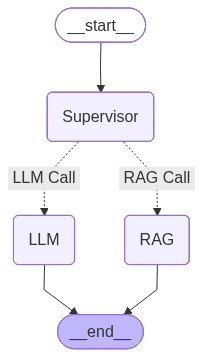

In [167]:
from IPython.display import Image, display

# Generate and display the workflow graph
display(Image(app.get_graph().draw_mermaid_png()))
